<a href="https://colab.research.google.com/github/Evg20095/Neuro-network/blob/master/Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 7111 (delta 2), reused 2 (delta 0), pack-reused 7093
Receiving objects: 100% (7111/7111), 9.86 MiB | 9.63 MiB/s, done.
Resolving deltas: 100% (4801/4801), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
import numpy as np
import pandas as pd
import os
import shutil
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [0]:
import re
splitter = re.compile("\s+")

**Блок предобработки данных**
> Это часть кода может быть непонятна. Но не стоит переживать. Тут я просто подготавливаю train к загрузке в нейронную сеть.



In [0]:
base_path = '/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/'
jeans_path = '/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/img/train/Jeans/'
bbox_list_path = '/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/Anno/list_bbox.txt'

In [0]:
# Эта функция перераспределяет img в папках и меняет им названия
def move_img(bbox_list_path, jeans_path, base_path):
    with open(bbox_list_path, 'r') as bbox_file:
        list_bbox_partition = [line.rstrip('\n') for line in bbox_file][2:]
        list_bbox_partition = [splitter.split(line) for line in list_bbox_partition]
        print(list_bbox_partition[0])
        print()
        list_all=[]
        for row in list_bbox_partition:
            if row[0].split('/')[1].split('_')[-1] == 'Jeans':
                list_all.append(row[0][:4] + 'train/Jeans/' + row[0][4:])
        print()
        print(list_all[0:2])
    # этот цикл используется для наглядности
    for row in list_all[:3]:
        print(os.path.join(jeans_path, row.split('/')[-1]))
        print(os.path.join(jeans_path, row.split('/')[-2] + '_' + row.split('/')[-1]))
        print()
    
    for row in list_all:
        if os.path.exists(os.path.join(base_path, row)):
            shutil.move(os.path.join(base_path, row), jeans_path)
            os.rename(os.path.join(jeans_path, row.split('/')[-1]), os.path.join(jeans_path, row.split('/')[-2] + '_' + row.split('/')[-1]))
# move_img() # тут нехватает аргументов, намеренно, что бы не запускать функцию заново. Она уже отработала.

In [0]:
imgs = list(sorted(os.listdir('/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/img/train/Jeans')))

In [0]:
bbox_list_path = '/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/Anno/list_bbox.txt'
with open(bbox_list_path, 'r') as bbox_file:
    list_bbox_partition = [line.rstrip('\n') for line in bbox_file][2:] # Разделим содержимое файла по строчка и в массив
    list_bbox_partition = [splitter.split(line) for line in list_bbox_partition] # Разделим каждую строчку по пробелам. Получился массив массивов
    jeans_all = [ line for line in list_bbox_partition if line[0].split('/')[1].split('_')[-1] == 'Jeans'] # из всех строчек остаим только Jeans
    jeans_all = sorted(jeans_all) # отсортируем 
    name_img_bbox = [[line[0].split('/')[1] + '_' + line[0].split('/')[2], line[1], line[2], line[3], line[4]] for line in jeans_all] # оставим в строчках только название картинки и bbox

In [0]:
# В img_bbox будут хранится только те img-bbox, которые есть в Jeans
img_bbox = [] 
for row in imgs:
  for line in name_img_bbox:
    if row == line[0]:
      img_bbox.append(line)

In [0]:
# поэлементная проверка совпадения
for n in range(5126):
  if  not img_bbox[n][0] == imgs[n]: print('break')

В итоге мы получили список содержащий в каждом елементе название картинки и bbox к ней.

In [0]:
img_bbox[10]

['Acid_Wash_-_Skinny_Jeans_img_00000014.jpg', '059', '001', '195', '286']

Конец предобработки

# Напишем класс torch.utils.data.Dataset 

In [0]:
import torch
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models

In [0]:
class data_jeans(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
      self.root = root
      self.img_bbox = img_bbox
      self.transforms = transforms

    def __getitem__(self, idx):
      # получим изображения
      img_path = os.path.join(self.root, "train/Jeans", self.img_bbox[idx][0])
      img = Image.open(img_path).convert("RGB")
      # data_transforms = transforms.Compose([transforms.ToTensor()])
      # img = data_transforms(img)
      # получим bounding box`ы
      boxes = img_bbox[idx][1:5]
      boxes = [float(coodinate) for coodinate in boxes]
      boxes = [boxes]
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      
      label = torch.ones((1,), dtype=torch.int64)

      target = {}
      target['boxes'] = boxes
      target['labels'] = label
      
      if self.transforms is not None:
          img, target = self.transforms(img, target)

      return img, target
    def __len__(self):
      return len(self.img_bbox)

In [0]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

/////-----------------------Соберём *модель*-------------------------/////

In [0]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [0]:
# Подготовка данных к загрузке 
root = '/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/img'
# dataset = data_jeans(root, )
dataset = data_jeans(root, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=8, collate_fn=utils.collate_fn)

In [0]:
dataset[0]

(tensor([[[0.6588, 0.6588, 0.6588,  ..., 0.6588, 0.6588, 0.6588],
          [0.6588, 0.6588, 0.6588,  ..., 0.6588, 0.6588, 0.6588],
          [0.6588, 0.6588, 0.6588,  ..., 0.6588, 0.6588, 0.6588],
          ...,
          [0.7765, 0.7765, 0.7765,  ..., 0.7725, 0.7725, 0.7725],
          [0.7882, 0.7882, 0.7882,  ..., 0.7922, 0.7922, 0.7922],
          [0.8314, 0.8314, 0.8314,  ..., 0.8314, 0.8314, 0.8314]],
 
         [[0.6745, 0.6745, 0.6745,  ..., 0.6745, 0.6745, 0.6745],
          [0.6745, 0.6745, 0.6745,  ..., 0.6745, 0.6745, 0.6745],
          [0.6745, 0.6745, 0.6745,  ..., 0.6745, 0.6745, 0.6745],
          ...,
          [0.7922, 0.7922, 0.7922,  ..., 0.7882, 0.7882, 0.7882],
          [0.8039, 0.8039, 0.8039,  ..., 0.8078, 0.8078, 0.8078],
          [0.8471, 0.8471, 0.8471,  ..., 0.8471, 0.8471, 0.8471]],
 
         [[0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ..., 0.6863, 0.6863, 0.6863],
          [0.6863, 0.6863, 0.6863,  ...,

////------------------Выберем гиперпараметры-------------------/////

In [0]:
# Выберем устройство для расчёта
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
num_classes = 2 # Колличество классов, которых хотим получить
model = get_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [0]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()

In [0]:
# Сохраним модель
# torch.save(model, '/content/gdrive/My Drive/Colab Notebooks/checkpoint2.pth')

In [0]:
# Загрузим модель
the_model = torch.load('/content/gdrive/My Drive/Colab Notebooks/checkpoint2.pth')

**Тестируем модель**

In [0]:
data_transforms = transforms.Compose([transforms.ToTensor()])
img = Image.open('/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/img/test/img_00000032.jpg').convert("RGB")
img = data_transforms(img)
# переведём модель в режим оценки
the_model.eval()
with torch.no_grad():
    prediction = the_model([img.to(device)])

In [0]:
import cv2  

In [0]:
device_cpu = torch.device('cpu')
coordinates = prediction[0]['boxes'].to(device_cpu)
coordinates = coordinates[0].numpy()
x_min = int(coordinates[0])
y_min = int(coordinates[1])
x_max = int(coordinates[2])
y_max = int(coordinates[3])
print(x_min, y_min, x_max, y_max)

116 120 180 280


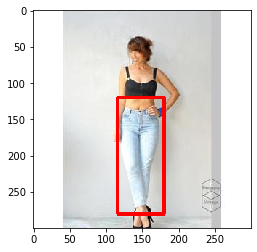

In [0]:
path_test_img = '/content/gdrive/My Drive/Colab Notebooks/fashion_gcollab_jeans/img/test/img_00000032.jpg'
image = cv2.imread(path_test_img)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
start_point = (x_min, y_min)
end_point = (x_max, y_max)
color = (255, 0, 0)
thickness = 3
image = cv2.rectangle(rgb_image, start_point, end_point, color, thickness)
plt.imshow(image)